# Определение перспективного тарифа для телеком-компании

### Описание проекта

#### Постановка задачи

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Краткое описание последовательности выполнения проекта**

* Загрузка файлов, их изучение и подготовка к дальнейшему анализу.
* Расчёт метрик для каждого пользователя: количество звонков и израсходованных минут, количество сообщений и объём потраченного интернет-трафика по месяцам. Расчёт помесячной выручки с каждого пользователя.
* Анализ полученных данных - описание поведения клиентов в зависимости от тарифа.
* Проверка гипотез - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются; средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
* Выводы по проекту.

#### Описание тарифов

**Тариф «Смарт»**

1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
     * минута разговора: 3 рубля
     * сообщение: 3 рубля
     * 1 Гб интернет-трафика: 200 рублей
    
    
     
**Тариф «Ультра»**

1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
     * минута разговора: 1 рубль
     * сообщение: 1 рубль
     * 1 Гб интернет-трафика: 150 рублей

**Примечание**

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

#### Описание данных

**Таблица users (информация о пользователях):**

* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана

**Таблица calls (информация о звонках):**

* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

**Таблица messages (информация о сообщениях):**

* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях):**

* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя


**Таблица tariffs (информация о тарифах):**

* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Загрузка данных и подготовка их к анализу

### Загрузка и обзор данных из файлов

In [1]:
#Импорт библиотек
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats as st
import numpy as np
from IPython.display import display
import warnings
import seaborn as sns

# отключение уведомлений об ошибке при замене исходного набора данных
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# показ всех колонок датафрейма
pd.options.display.max_columns = None

In [2]:
# загружаем файлы в переменные и выводим на экран
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv', index_col=0)
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

# выделим основные таблицы
main_tables = [users, calls, messages, internet]

# и выведем первые 5 строк каждой таблицы
for table in main_tables:
    display(table.head())
display(tariffs.head())

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Посмотрим подробности о данных

In [3]:
for table in main_tables:
    display(table.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


None

**Выводы**

Пропусков в данных не обнаружено. Столбцы с датами можно привести к типу `datetime`, но можно обойтись и классическими питоновскими методами, чтобы достать месяц из даты. 

### Предобработка данных

#### Обработка дубликатов

In [4]:
for table in main_tables:
    print(table.duplicated().sum())

0
0
0
0


In [5]:
for table in main_tables:
    if 'id' in table.columns:
        print(table.duplicated().sum())

0
0
0


**Вывод**

Явных дубликатов в основных таблицах не обнаружено. Неявные дубликаты так же не обнаружены.

#### Удаление необязательных для анализа столбцов

В таблице `users` оставим только столбцы с id пользователя, его городом и тарифом. Только эти столбцы будут важны для дальнейшего анализа. Аналогично для таблицы `internet` - оставляем только нужные для анализа столбцы.

In [6]:
users = users[['user_id', 'city', 'tariff']]
internet = internet[['id', 'mb_used', 'session_date', 'user_id']]

#### Изменение типа данных столбцов

Поменяем тип столбцов в основных таблицах на тип `category` для экономии памяти.

In [7]:
internet['session_date'] = internet['session_date'].astype('category')
calls['call_date'] = calls['call_date'].astype('category')
messages['message_date'] = messages['message_date'].astype('category')

#### Округление времени разговора в бОльшую сторону

По условию задания сказано, что время разговора всегда округляется в бОльшую сторону (секунды до минут), поэтому приведем столбец с временем разговора к нужному формату. 

In [8]:
calls['duration'] = calls['duration'].apply(np.ceil)

### Выделение месяца в отдельный столбец

Из колонки с датой в таблицах разговоров, сообщений и интернета выделим месяц в отдельный столбец для дальнешйего помесячного анализа поведения пользователей.

In [9]:
internet['month'] = internet['session_date'].str.split('-').str[1].astype('category')
calls['month'] = calls['call_date'].str.split('-').str[1].astype('category')
messages['month'] = messages['message_date'].str.split('-').str[1].astype('category')

## Расчёт метрик для пользователей

### Количество сделанных звонков и потраченных минут разговора по месяцам

С помощью группировки по id пользователя и месяцу рассчитаем необходимые нам метрики (время потраченных минут разговора, количество звонков, количество сообщений и количество использованных мб интернет трафика). 

In [10]:
calls_group = (calls.groupby(['user_id', 'month'])['duration'] 
                     .agg(['sum', 'count']) 
                     .reset_index()
                     .rename(columns={'sum':'minutes_spent', 'count':'calls_count'}))
calls_group.head()

,user_id,month,minutes_spent,calls_count
0,1000,01,0.0,0
1,1000,02,0.0,0
2,1000,03,0.0,0
3,1000,04,0.0,0
4,1000,05,159.0,22


### Количество отправленных сообщений по месяцам

In [11]:
messages_group = (messages.groupby(['user_id', 'month'])['id']
                  .agg('count')
                  .reset_index()
                  .rename(columns={'id':'messages_sent'}))
messages_group.head()

,user_id,month,messages_sent
0,1000,01,0
1,1000,02,0
2,1000,03,0
3,1000,04,0
4,1000,05,22


### Объем потраченного интернет-трафика по месяцам

In [12]:
internet_group = (internet.groupby(['user_id', 'month'])['mb_used']
                  .agg('sum')
                  .reset_index())

internet_group['mb_used'] = internet_group['mb_used'].apply(lambda x: np.ceil(x/1024) * 1024)
internet_group.head(10)

,user_id,month,mb_used
0,1000,01,0.0
1,1000,02,0.0
2,1000,03,0.0
3,1000,04,0.0
4,1000,05,3072.0
5,1000,06,23552.0
6,1000,07,14336.0
7,1000,08,14336.0
8,1000,09,15360.0
9,1000,10,15360.0


### Помесячная выручка с каждого пользователя

Теперь рассчитаем выручку с каждого пользователя по месяцам. Для этого сначала создадим общую таблицу, по которой и будет проводиться расчёт выручки. Затем создадим и применим функцию для этого расчёта.

In [13]:
users_revenue = (calls_group
                .drop(columns='calls_count') # убираем ненужную для дальнейшего анализа колонку с количеством звонков
                .merge(messages_group, on=['user_id', 'month'], how='outer') # присоединяем нужные таблицы с сообщениями
                .merge(internet_group, on=['user_id', 'month'], how='outer') # таблицу с интернетом
                .merge(users, on='user_id')) # и с пользователями

# заполнение пропусков ноликами
users_revenue[['minutes_spent', 'messages_sent', 'mb_used']] =(
 users_revenue[['minutes_spent', 'messages_sent', 'mb_used']]).fillna(0)

# отфильтруем таблицу так, чтобы убрать строки, 
# когда пользователь ещё не был зарегистрирован (использование всего тарифа за месяц равно 0)
users_revenue = (users_revenue.drop(users_revenue.query('(minutes_spent == 0 and messages_sent == 0 and mb_used == 0)').index))
users_revenue.head()

,user_id,month,minutes_spent,messages_sent,mb_used,city,tariff
4,1000,05,159.0,22.0,3072.0,Краснодар,ultra
5,1000,06,172.0,60.0,23552.0,Краснодар,ultra
6,1000,07,340.0,75.0,14336.0,Краснодар,ultra
7,1000,08,408.0,81.0,14336.0,Краснодар,ultra
8,1000,09,466.0,57.0,15360.0,Краснодар,ultra


In [15]:
# функция будет возвращать доход с пользователя в зависимости от его тарифа и
# от использованных им за месяц услуг этого тарифа

def revenue(row):
    
    minutes = row['minutes_spent']
    messages = row['messages_sent']
    mb = row['mb_used']
    tariff = row['tariff']
    
    if tariff == 'ultra':
        payment = 1950
        
        if minutes > 3000:
            payment += (minutes - 3000) * 1
        if messages > 1000:
            payment += (messages - 1000) * 1
        if mb > 30720:
            payment += ((mb - 30720) / 1024) * 150
                    
    if tariff == 'smart':
        payment = 550
        
        if minutes > 500:
            payment += (minutes - 500) * 3
        if messages > 50:
            payment += (messages - 50) * 3
        if mb > 15360:
            payment += ((mb - 15360) / 1024) * 200
    
    return(payment)


In [16]:
users_revenue['revenue'] = users_revenue.apply(revenue, axis=1)
users_revenue.head()

,user_id,month,minutes_spent,messages_sent,mb_used,city,tariff,revenue
4,1000,05,159.0,22.0,3072.0,Краснодар,ultra,1950.0
5,1000,06,172.0,60.0,23552.0,Краснодар,ultra,1950.0
6,1000,07,340.0,75.0,14336.0,Краснодар,ultra,1950.0
7,1000,08,408.0,81.0,14336.0,Краснодар,ultra,1950.0
8,1000,09,466.0,57.0,15360.0,Краснодар,ultra,1950.0


**В итоговой таблице есть все нужные столбцы**

## Исследовательский анализ данных

### Поведение клиентов разных тарифов и доход с них

Создадим таблицу с количеством пользователей двух тарифов для расчёта общей прибыли с каждого тарифа

In [17]:
user_tariff_count = (users.groupby('tariff')['user_id']
                     .agg('count')
                     .reset_index()
                     .rename(columns={'user_id':'user_count'}))
user_tariff_count

,tariff,user_count
0,smart,351
1,ultra,149


Теперь с помощью группировки создадим таблицу, в которой будут средние значения использования услуг каждого из тарифов, а также количество пользователей, средний доход с пользователя и общий доход со всех пользователей.

In [18]:
users_revenue_group = (users_revenue.groupby('tariff')['minutes_spent', 'messages_sent', 'mb_used', 'revenue']
                       .agg('mean')
                       .round()
                       .reset_index()
                       .merge(user_tariff_count, on='tariff')
                       .rename(columns={'revenue':'avg_revenue'}))

users_revenue_group['total_revenue'] = users_revenue_group['avg_revenue'] * users_revenue_group['user_count']
users_revenue_group

,tariff,minutes_spent,messages_sent,mb_used,avg_revenue,user_count,total_revenue
0,smart,418.0,33.0,16721.0,1290.0,351,452790.0
1,ultra,527.0,49.0,19962.0,2070.0,149,308430.0


**Выводы**

Таблица выше наглядно показывает различие в поведении пользователей разных тарифов. Так, пользователи тарифа `smart` в среднем не выходят за пределы тарифа по количеству потраченных минут и отправленных сообщений (418 минут и 33 сообщения при лимите в тарифе в 500 минут и 50 сообщений). Пользователи этого тарифа в среднем слегка выходят за рамки использованного интернет трафика (16721 мб при лимите в 15360 мб), благодаря чему дополнительно за него доплачивают. 

Пользователи тарифа `ultra` не выходят за рамки лимитов своего тарифа, что сказывается на среднем доходе с пользователя - 2058 рублей при базовой цене тарифа в 1950 рублей (для тарифа `smart` соответственно средний доход с пользователя 1290 рублей при базовой цене тарифа в 550 рублей).

Таким образом, пользователи тарифа `ultra` пользуются всеми возможностями своего тарифа, редко выходя за его рамки, можно даже сказать, что пользователи этого тарифа не используют его на полную мощность (особенно заметно на примере потраченных минут разговора - 527 минут в среднем при лимите в 3000 минут). А пользователи тарифа `smart` в среднем выходят за рамки лимита по интернет-трафику, при этом оставаясь в границах лимитов по минутам разговора и сообщениям.
 
По расчёту общей прибыли с пользователей разных тарифов можно сказать, что пользователи тарифа `smart` приносят больше прибыли (452790 рублей - тариф smart и 308430 рублей - тариф ultra). 

### Статистическое описание основных метрик

Расчитаем дисперсию и стандартное отклонение для основных метрик, сделаем мы это с помощью группировки и функций из библиотеки `numpy`

#### Дисперсия

In [19]:
users_variance_group = (users_revenue.groupby('tariff')['minutes_spent', 'messages_sent', 'mb_used']
                        .agg(np.var)
                        .round()
                        .reset_index())

users_variance_group

,tariff,minutes_spent,messages_sent,mb_used
0,smart,36219.0,797.0,34633108.0
1,ultra,100874.0,2285.0,101808012.0


#### Стандартное отклонение

In [20]:
users_std_group = (users_revenue.groupby('tariff')['minutes_spent', 'messages_sent', 'mb_used']
                   .agg(np.std)
                   .round()
                   .reset_index())

users_std_group

,tariff,minutes_spent,messages_sent,mb_used
0,smart,190.0,28.0,5885.0
1,ultra,318.0,48.0,10090.0


#### Гистограммы метрик

Теперь построим гистрограммы распределения основных метрик, для этого создадим функцию, которая построит все графики сразу

In [21]:
def plot_hist(df):

    # задаём размер сетки для графиков
    plt.figure(figsize=(16, 12))
    # задаём размер сетки для графиков
    sns.set(font_scale = 1.1)

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # задаём параметры для первого графика - распределние потраченных минут разговора
    ax1 = plt.subplot(2, 2, 1)
    sns.histplot(data=df, x='minutes_spent', kde=True, hue='tariff')
    
    ax1.set_xlabel('Минут потрачено', fontsize = 13)
    ax1.set_ylabel('Количество пользователей', fontsize = 13)
    ax1.set_title('Распределение потраченных минут разговора', fontsize = 14)
    ax1.legend(title='Тариф', labels=['smart', 'ultra'], fontsize = 13, title_fontsize = 13)
    
    # задаём параметры для второго графика - распределние отправленных сообщений
    ax2 = plt.subplot(2, 2, 2)
    sns.histplot(data=df, x='messages_sent', kde=True, hue='tariff')
    
    ax2.set_xlabel('Сообщений отправлено', fontsize = 13)
    ax2.set_ylabel('Количество пользователей', fontsize = 13)
    ax2.set_title('Распределение отправленных сообщений', fontsize = 14)
    ax2.legend(title='Тариф', labels=['smart', 'ultra'], fontsize = 13, title_fontsize = 13)
    
    # задаём параметры для третьего графика - распределние использованного интернет трафика
    ax3 = plt.subplot(2, 2, 3)
    sns.histplot(data=df, x='mb_used', kde=True, hue='tariff')
    
    ax3.set_xlabel('МБ использовано', fontsize = 13)
    ax3.set_ylabel('Количество пользователей', fontsize = 13)
    ax3.set_title('Распределение потраченного трафика', fontsize = 14)
    ax3.legend(title='Тариф', labels=['smart', 'ultra'], fontsize = 13, title_fontsize = 13)

    plt.show()

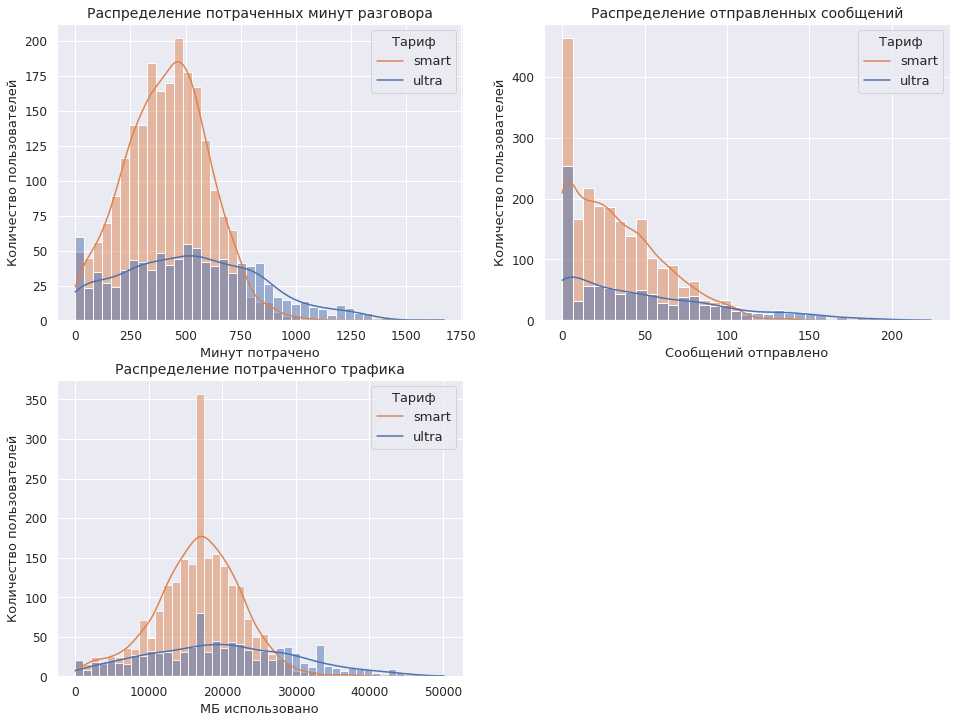

In [22]:
plot_hist(users_revenue)

In [23]:
# чтобы нагляднее можно было посмотреть средние значения
users_revenue_group.drop(columns=['avg_revenue', 'user_count', 'total_revenue'])

,tariff,minutes_spent,messages_sent,mb_used
0,smart,418.0,33.0,16721.0
1,ultra,527.0,49.0,19962.0


In [24]:
# расчёт процента пользователей, которые превысили ежемесячные лимиты по своему тарифу
users_ultra_exceeds_limits = ((users_revenue.query('tariff == "ultra" and revenue != 1950'))['tariff'].count() / 
                             (users_revenue.query('tariff == "ultra"'))['tariff'].count())

users_smart_exceeds_limits = ((users_revenue.query('tariff == "smart" and revenue != 550'))['tariff'].count() / 
                             (users_revenue.query('tariff == "smart"'))['tariff'].count())

print("Процент пользователей тарифа ultra, превысивших лимиты тарифа: " + "{:.1%}".format(users_ultra_exceeds_limits))
print("Процент пользователей тарифа smart, превысивших лимиты тарифа: " + "{:.1%}".format(users_smart_exceeds_limits))

Процент пользователей тарифа ultra, превысивших лимиты тарифа: 13.6%
Процент пользователей тарифа smart, превысивших лимиты тарифа: 74.6%


**Выводы**

* Все гистограммы имеют нормальное распределение
* Распределение потраченных минут разговора для тарифа smart незначительно смещено вправо, для тарифа ultra смещение вправо более существенное 
* Распределение отправленных сообщений для обоих тарифов смещено вправо. Так же очень сильно выделяются пользователи, которые не отправили ни одного сообщения. 
* Распределение потраченного интернет трафика для тарифа smart является несмещенным нормальным распределением, для тарифа ultra распределение незначительно смещено вправо
* Пользователи тарифа smart намного чаще превышают лимиты по своему тарифу, чем пользователи тарифа ultra (74.6% у тарифа smart и 13.6% у тарифа ultra при общем количестве пользователей этих тарифов в 349 и 151 человек соответственно). Это различие в процентах обусловлено тем, что пользователи тарифа smart часто превышают лимит своего тарифа по интернет-трафику.

## Проверка гипотез

### Гипотеза 1 - средняя выручка двух тарифов различается

В одном из вышеприведненных пунктов я уже расчитывал среднюю выручку по тарифам, теперь подтвердим это статистически. Для проверки гипотезы будем использовать функцию `stats.ttest_ind`, так как мы будем рассматривать средние двух независимых совокупностей (пользователей двух тарифов). Нулевой гипотезой будет равенство средней выручки с двух тарифов.

In [25]:
ultra_revenue = users_revenue.query('tariff == "ultra"')['revenue']
smart_revenue = users_revenue.query('tariff == "smart"')['revenue']

alpha = .05

results = st.ttest_ind(ultra_revenue, smart_revenue)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.4229814360764067e-160
Отвергаем нулевую гипотезу


**Вывод**

Мы отвергаем нулевую гипотезу о равенстве средней выручки с пользователей двух тарифов, так как p-значение ниже критического уровеня значимости (который мы задали равным 0.05).

Таким образом, подтвердилась альтернативная гипотеза о неравенстве средней выручки с пользователей разных тарифов

### Гипотеза 2 - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Для второй гипотезы так же будем использовать функцию `stats.ttest_ind`, так как снова будем рассматривать средние двух независимых совокупностей (пользователей из Москвы и других городов). Нулевой гипотезой будет равенство средней выручки с пользователей из Москвы и пользователей из других регионов.

In [26]:
moscow_revenue = users_revenue.query('city == "Москва"')['revenue']
not_moscow_revenue = users_revenue.query('city != "Москва"')['revenue']

results = st.ttest_ind(moscow_revenue, not_moscow_revenue)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


In [27]:
print('Средний доход с пользователей из Москвы', users_revenue.query('city == "Москва"')['revenue'].agg('mean').round())
print('Средний доход с пользователей не из Москвы', users_revenue.query('city != "Москва"')['revenue'].agg('mean').round())

Средний доход с пользователей из Москвы 1547.0
Средний доход с пользователей не из Москвы 1525.0


**Выводы**

Нулевую гипотезу не получилось отвергнуть (так как p-значение выше критического значения в 0.05), соответственно, средний доход с пользователей из Москвы и из других городов практически равны. Это так же подтверждает расчёт средних значений дохода, который приведён выше.

## Выводы по исследованию

* В проекте были расчитаны все основные метрики для пользователей разных тарифов - потраченные минуты разговора, использованные сообщения и мб интернет трафика, а так же доход с каждого пользователя за месяц.
* Было изучено поведение клиентов двух тарифов. Мы установили, что пользователи тарифа smart в среднем превышают лимиты по интернет-трафику, по потраченным минутам разговора и сообщениям они остаются в пределах лимитов тарифа. Пользователи тарифа ultra в среднем остаются в лимитах по всем услугам своего тарифа. Это сказывается на среднем доходе с пользователя - 2058 рублей при базовой цене тарифа в 1950 рублей (для тарифа smart соответственно средний доход с пользователя 1290 рублей при базовой цене тарифа в 550 рублей).
* Построенные гистограммы распределения количества пользователей по основным метрикам позволили сделать вывод о том, что поведение пользователей разных тарифов практически не отличается (разница в расходах минут разговора, сообщениях, и мб трафика незначительна).
* Расчёт выручки с пользователей дал возможность выбрать оптимальный тариф. Лучшим тарифом из двух является тариф smart, так как его выбирает большинство пользователей, и в пересчёте на общую прибыль этот тариф приносит больше денег (452790 рублей против 308430 рублей у тарифа ultra). Хотя тариф ultra приносит больше денег с одного пользователя, но этот тариф выбирают реже, чем тариф smart, поэтому общий заработок с тарифа ultra и меньше.
* Моя рекомендация состоит в том, что не стоит делать ставку на раскрутку услуг компании в только в одной Москве, стоит равномерно продвигать услуги по всей стране, так как средний доход с пользователя в Москве практически равен среднему доходу с пользователя в других регионах (что было показано в проверке соответствующей гипотезы в пункте 4.2.).